# Lesson 2

### Setup

In [1]:
%matplotlib inline
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import *

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


In [2]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

### Playground

In [3]:
??get_data

### Linear Model with Keras

In [4]:
x = random((30,2 ))
x[:5]

array([[ 0.3269,  0.5419],
       [ 0.1249,  0.98  ],
       [ 0.9571,  0.3572],
       [ 0.4791,  0.5451],
       [ 0.3326,  0.9215]])

In [5]:
y = np.dot(x, [4., 5.]) + 6.
y[:5]

array([ 10.0168,  11.3996,  11.6146,  10.642 ,  11.9376])

In [6]:
linear_model = Sequential([Dense(1, input_shape=(2,))])
linear_model.compile(optimizer=SGD(lr=0.01), loss='mse')

In [7]:
linear_model.evaluate(x, y, verbose=0)

100.21261596679688

In [8]:
linear_model.fit(x, y, nb_epoch=30, batch_size=1, verbose=0)

In [9]:
linear_model.evaluate(x, y)

30/30 [==============================] - 0s


0.003662418806925416

In [10]:
linear_model.get_weights()

[array([[ 3.8326],
        [ 4.8229]], dtype=float32), array([ 6.1829], dtype=float32)]

### Linear Model with VGG

So we now have a basic model that is able to convert any input to any output using the universal function, we can just use the 1000 output from the vgg model and fit it to 2 output.

In [11]:
path = "data/dogscats/"
model_path = path + "models/"
if not os.path.exists(model_path): os.mkdir(model_path)

In [12]:
batch_size = 100

In [13]:
val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
batches = get_batches(path+'train', shuffle=False, batch_size=1)

Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.


In [14]:
from vgg16 import Vgg16

In [15]:
vgg = Vgg16()

In [16]:
model = vgg.model

Todos:
1. Get labels for all images
2. Get predictions for all images.
3. Use a linear model to fit the predictions to isDog/isCat

In [17]:
val_data = get_data(path+'valid')
trn_data = get_data(path+ 'train')

Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.


In [18]:
trn_data.shape

(23000, 3, 224, 224)

In [19]:
save_array(model_path+ 'train_data.bc', trn_data)
save_array(model_path+'valid_data.bc', val_data)

In [20]:
trn_data = load_array(model_path+'train_data.bc')
val_data = load_array(model_path+'valid_data.bc')

In [27]:
val_data.shape

(2000, 3, 224, 224)

In [29]:
def onehot(x): 
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [28]:
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

In [32]:
trn_labels.shape
trn_classes[:4]
trn_labels[:4]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [33]:
trn_features = model.predict(trn_data, batch_size=batch_size)
val_features = model.predict(val_data, batch_size=batch_size)

In [35]:
trn_features.shape

(23000, 1000)

In [36]:
trn_features[:5]

array([[  1.4135e-05,   3.8687e-07,   8.6534e-06, ...,   4.9458e-06,   4.6688e-04,   4.6785e-03],
       [  3.8557e-06,   1.5945e-05,   1.4344e-06, ...,   3.0623e-06,   2.3711e-04,   1.5105e-04],
       [  4.7311e-07,   1.6243e-05,   2.1749e-06, ...,   2.8995e-07,   6.4160e-05,   5.9271e-03],
       [  2.1218e-07,   5.6982e-07,   9.7189e-07, ...,   2.3288e-06,   3.6301e-05,   7.4142e-04],
       [  1.4311e-06,   2.1720e-05,   1.4053e-05, ...,   1.7267e-06,   2.5162e-04,   5.2056e-04]], dtype=float32)

In [37]:
# 1000 inputs, since that's the saved features, and 2 outputs, for dog and cat
lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
batch_size=64

In [39]:
lm.fit(trn_features, trn_labels, nb_epoch=3, batch_size=batch_size, 
       validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 0s - loss: 0.0981 - acc: 0.9660 - val_loss: 0.0972 - val_acc: 0.9665
Epoch 2/3
23000/23000 [==============================] - 0s - loss: 0.0793 - acc: 0.9752 - val_loss: 0.1092 - val_acc: 0.9635
Epoch 3/3
23000/23000 [==============================] - 0s - loss: 0.0795 - acc: 0.9765 - val_loss: 0.1093 - val_acc: 0.9695


In [40]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_5 (Dense)                  (None, 2)             2002        dense_input_2[0][0]              
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
____________________________________________________________________________________________________


In [49]:
# We want both the classes...
preds = lm.predict_classes(val_features, batch_size=batch_size)
# ...and the probabilities of being a cat
probs = lm.predict_proba(val_features, batch_size=batch_size)[:,0]
probs[:8]

  64/2000 [..............................] - ETA: 0s

array([ 1.    ,  0.3276,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ], dtype=float32)

In [50]:
preds[:5]

array([0, 1, 0, 0, 0])

In [51]:
filenames  = val_batches.filenames
n_view = 4

In [52]:
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

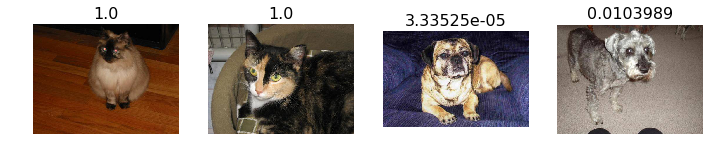

In [53]:
#1. A few correct labels at random
correct = np.where(preds==val_labels[:,1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

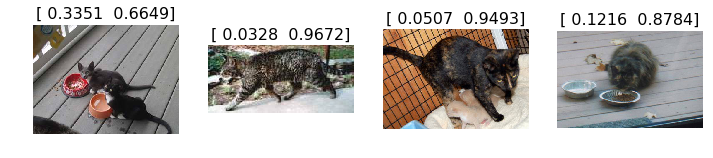

In [46]:
#2.  A few incorrect labels at random
incorrect = np.where(preds!=val_labels[:,1])[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

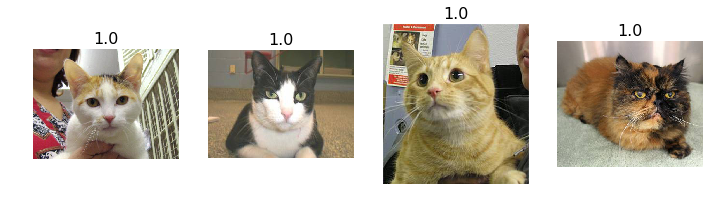

In [54]:
#3. The images we most confident were cats, and are actually cats
correct_cats = np.where((preds==0) & (preds==val_labels[:,1]))[0]
most_correct_cats = np.argsort(probs[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], probs[correct_cats][most_correct_cats])

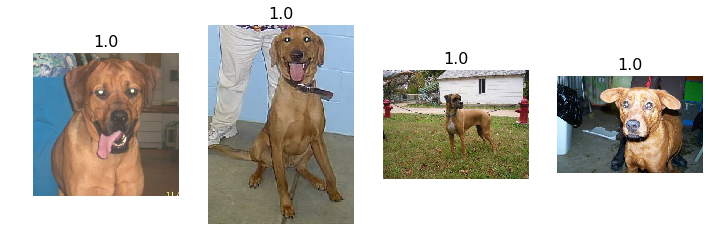

In [55]:
# as above, but dogs
correct_dogs = np.where((preds==1) & (preds==val_labels[:,1]))[0]
most_correct_dogs = np.argsort(probs[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], 1-probs[correct_dogs][most_correct_dogs])